In [1]:
import numpy as np
import pandas as pd

## Load Data

In [2]:
data = ['five-mer.csv', 'six-mer.csv', 'seven-mer.csv', 'ordinal_encoding.csv', 'subseq_natural_vector.csv']

########## EDIT HERE TO CHANGE DATASET ##########
dat_idx = 0 # index to choose the dataset, [0,4]
#################################################

file_path = "../data/" + data[dat_idx]
dat_name = data[dat_idx][:-4] 
df = pd.read_csv(file_path, header=None)

label = '../data/label.txt'
y = np.loadtxt(label, dtype='str')

In [3]:
num_classes = len(np.unique(y))
num_classes

28

In [4]:
num_samples = len(df.index)
print("Number of Samples: ", num_samples)

num_features = len(df.columns)
print("Number of Features: ", num_features)

Number of Samples:  15018
Number of Features:  1024


In [5]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

## Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
test_indices = pd.DataFrame(X_test.index, columns=['test index'])
test_indices.to_csv('../feature_selection/test_indices.csv', index=False)

In [7]:
num_training_samples = len(y_train)
print("Number of Training Samples: ", num_training_samples)

Number of Training Samples:  12014


## PCA

In [8]:
from sklearn.decomposition import PCA

# n_components = 512

# pca = PCA(n_components=n_components)
# pca_features = pca.fit_transform(df)
# explained_variance_ratio = sum(pca.explained_variance_ratio_[:n_components])

In [9]:
lower_bound = round(num_features/20)
upper_bound = round(num_features/3)

explained_variances = [] # for the plot
n_components = [] # for the plot

for i in range (lower_bound,upper_bound, 4):
    pca = PCA(n_components=i)
    pca_features = pca.fit_transform(X_train)
    explained_variance_ratio = sum(pca.explained_variance_ratio_[:i])
    explained_variances.append(explained_variance_ratio)
    n_components.append(i)
    print(str(i) + " components")

    if (round(explained_variance_ratio,2) >= 0.90):
        break

51 components
55 components
59 components
63 components
67 components
71 components
75 components
79 components
83 components
87 components
91 components
95 components
99 components
103 components
107 components
111 components
115 components
119 components
123 components
127 components
131 components
135 components
139 components
143 components
147 components
151 components
155 components
159 components
163 components
167 components
171 components
175 components
179 components
183 components
187 components
191 components
195 components
199 components
203 components
207 components
211 components
215 components
219 components
223 components
227 components
231 components
235 components
239 components
243 components
247 components
251 components
255 components
259 components


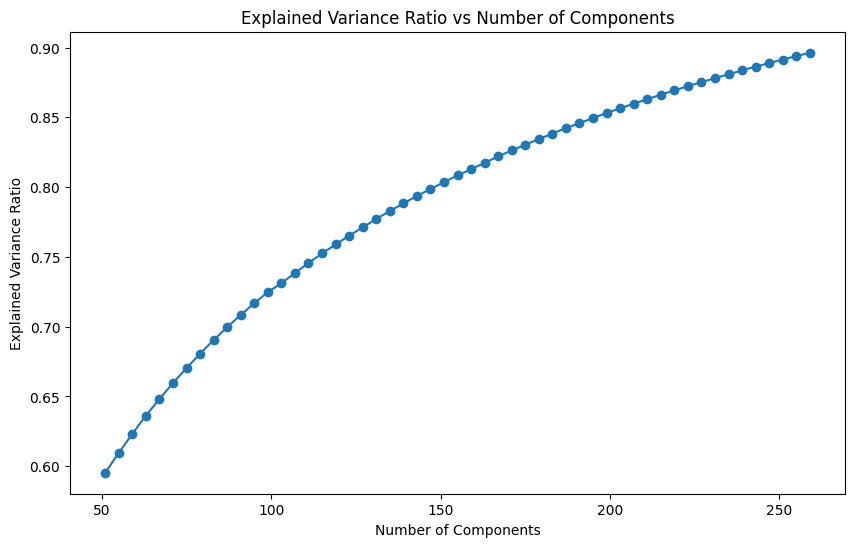

In [10]:
import matplotlib.pyplot as plt

# Plotting the curve
plt.figure(figsize=(10, 6))
plt.plot(n_components, explained_variances, marker='o')
plt.title("Explained Variance Ratio vs Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
#plt.grid(True)
plt.show()

In [11]:
num_selected_features = len(pca_features[0])
print("Number of Selected Features: ", num_selected_features)

Number of Selected Features:  259


In [12]:
print("PCA Explained Variance Ratio: ", explained_variance_ratio)

PCA Explained Variance Ratio:  0.8963219312178763


In [13]:
pca_transformed = pd.DataFrame(pca.transform(df))

In [14]:
save_df_name = '../feature_selection/PCA/' + 'pca_' + dat_name 
pca_transformed.to_csv(save_df_name + '.csv', index=False, header=False)

In [15]:
save_txt_name = '../feature_selection/PCA/' + 'pca_' + dat_name
with open(save_txt_name + '.txt', 'w') as f:
    f.write(dat_name + ' Number of Selected Features After PCA: ' + str(num_selected_features) + "\n")
    f.write(dat_name + ' PCA Cumulative Explained Variance Ratio: ' + str(explained_variance_ratio) )

## LR-LASSO

In [8]:
from sklearn.linear_model import LogisticRegressionCV

# Logistic Regression with L1 regularization for feature selection
log_reg = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear').fit(X_train, y_train)

# Mask for selecting features
lasso_mask = log_reg.coef_.sum(axis=0) != 0
selected_features_lasso = df.columns[lasso_mask]

save_df_name = '../feature_selection/LASSO/' + 'lasso_' + dat_name


In [9]:
df[selected_features_lasso].to_csv(save_df_name + '.csv', index=False, header=False)

In [10]:
save_txt_name = '../feature_selection/LASSO/' + 'lasso_' + dat_name
with open(save_txt_name + '.txt', 'w') as f:
    f.write(dat_name + ' Number of Selected Features After LR-LASSO: ' + str(len(selected_features_lasso)))

## 1-D CNN

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FS_1DCNN(nn.Module):
    def __init__(self, output_size=640):
        super(FS_1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=3)
        self.pool1 = nn.MaxPool1d(2, stride=3)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=3)
        self.pool2 = nn.MaxPool1d(2, stride=3)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.pool3 = nn.MaxPool1d(2, stride=2)
        self.fc1 = nn.Linear(output_size, 100)
        self.fc2 = nn.Linear(100, num_classes)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)  # Use the defined pooling layer
        x = F.relu(self.conv2(x))
        x = self.pool2(x)  # Use the defined pooling layer
        x = F.relu(self.conv3(x))
        x = self.pool3(x)  # Use the defined pooling layer

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [21]:
X_train_np = np.array(X_train)
X_reshaped = X_train_np.reshape(X_train_np.shape[0], 1, X_train_np.shape[1]) #(num_samples, 1, num_features)

# Convert to pytorch tensor
X_tensor = torch.tensor(X_reshaped, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)

In [ ]:
dummy_input = torch.randn(1, 1, num_features)
model = FS_1DCNN()

with torch.no_grad():
    dummy_output = dummy_input
    for layer in [model.conv1, model.pool1, model.conv2,model.pool2, model.conv3, model.pool3]:  # include all conv and pooling layers
        dummy_output = layer(dummy_output)

    dummy_output = dummy_output.view(dummy_output.size(0), -1)

output_size = dummy_output.shape[1]
print("Number of CNN selected features: ", output_size)

In [23]:
save_txt_name = '../feature_selection/1D-CNN/' + '1dcnn_' + dat_name
with open(save_txt_name + '.txt', 'w') as f:
    f.write(dat_name + ' Number of Selected Features After 1D-CNN: ' + str(output_size))

In [24]:
model = FS_1DCNN(output_size=output_size)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training
num_epochs = 100  
for epoch in range(num_epochs):
    # fp
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    # bp
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 3.2983
Epoch [2/100], Loss: 3.2784
Epoch [3/100], Loss: 3.2583
Epoch [4/100], Loss: 3.2363
Epoch [5/100], Loss: 3.2121
Epoch [6/100], Loss: 3.1843
Epoch [7/100], Loss: 3.1525
Epoch [8/100], Loss: 3.1167
Epoch [9/100], Loss: 3.0758
Epoch [10/100], Loss: 3.0295
Epoch [11/100], Loss: 2.9772
Epoch [12/100], Loss: 2.9179
Epoch [13/100], Loss: 2.8503
Epoch [14/100], Loss: 2.7744
Epoch [15/100], Loss: 2.6893
Epoch [16/100], Loss: 2.5946
Epoch [17/100], Loss: 2.4898
Epoch [18/100], Loss: 2.3745
Epoch [19/100], Loss: 2.2497
Epoch [20/100], Loss: 2.1170
Epoch [21/100], Loss: 1.9793
Epoch [22/100], Loss: 1.8411
Epoch [23/100], Loss: 1.7091
Epoch [24/100], Loss: 1.5915
Epoch [25/100], Loss: 1.4972
Epoch [26/100], Loss: 1.4342
Epoch [27/100], Loss: 1.4053
Epoch [28/100], Loss: 1.4066
Epoch [29/100], Loss: 1.4277
Epoch [30/100], Loss: 1.4561
Epoch [31/100], Loss: 1.4815
Epoch [32/100], Loss: 1.4976
Epoch [33/100], Loss: 1.5016
Epoch [34/100], Loss: 1.4948
Epoch [35/100], Loss: 1

In [25]:
def extract_features(data, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        features = model.conv1(data)
        features = model.pool1(features)
        features = model.conv2(features)
        features = model.pool2(features)  
        features = model.conv3(features)
        features = model.pool3(features)
        features = features.view(features.size(0), -1)  # flatten
    return features

X_all = np.array(df)
X_all_reshaped = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all_tensor = torch.tensor(X_all_reshaped, dtype=torch.float32)
extracted_features = extract_features(X_all_tensor, model)

In [26]:
extracted_features_np = extracted_features.numpy()
cnn_selected_features_df = pd.DataFrame(extracted_features_np)

In [27]:
save_df_name = '../feature_selection/1D-CNN/' + '1dcnn_' + dat_name
cnn_selected_features_df.to_csv(save_df_name + '.csv', index=False, header=False)